# **Files Upload**

In [2]:
from google.colab import files

uploaded = files.upload()


Saving courses.csv to courses.csv
Saving studentCourse.csv to studentCourse.csv
Saving studentNames.csv to studentNames.csv
Saving teachers.csv to teachers.csv


# **Code**

## Summary
My code generates an optimal university exam schedule using a Genetic Algorithm (GA). It reads course, student, and teacher data from CSV files and attempts to build a conflict-free timetable while optimizing for preferences.



Generation 1: Best Fitness = -480
Generation 2: Best Fitness = -480
Generation 3: Best Fitness = -460
Generation 4: Best Fitness = -460
Generation 5: Best Fitness = -360
Generation 6: Best Fitness = -360
Generation 7: Best Fitness = -300
Generation 8: Best Fitness = -300
Generation 9: Best Fitness = -300
Generation 10: Best Fitness = -300
Generation 11: Best Fitness = -300
Generation 12: Best Fitness = -300
Generation 13: Best Fitness = -300
Generation 14: Best Fitness = -300
Generation 15: Best Fitness = -300
Generation 16: Best Fitness = -300
Generation 17: Best Fitness = -300
Generation 18: Best Fitness = -300
Generation 19: Best Fitness = -300
Generation 20: Best Fitness = -300
Generation 21: Best Fitness = -300
Generation 22: Best Fitness = -300
Generation 23: Best Fitness = -300
Generation 24: Best Fitness = -300
Generation 25: Best Fitness = -300
Generation 26: Best Fitness = -300
Generation 27: Best Fitness = -300
Generation 28: Best Fitness = -300
Generation 29: Best Fitness =

,course_code,duration,day,start_time,room,invigilator
0,CS217,2,Friday,15,C305,Farah Jabeen Awan
1,EE227,1,Wednesday,9,C307,Sara Aziz
2,CS211,2,Thursday,13,C303,Ayesha Bano
3,SE110,1,Wednesday,16,C306,Zainab Abaid
4,CS118,2,Wednesday,15,C306,Ejaz Ahmed
5,CS219,1,Wednesday,14,C301,Asif Naeem
6,CS220,2,Thursday,10,C306,Usman Ashraf
7,CS302,2,Tuesday,16,C302,Usman Rashid
8,CY2012,1,Tuesday,11,C308,Amna Irum
9,CS307,2,Friday,12,C301,Amna Irum


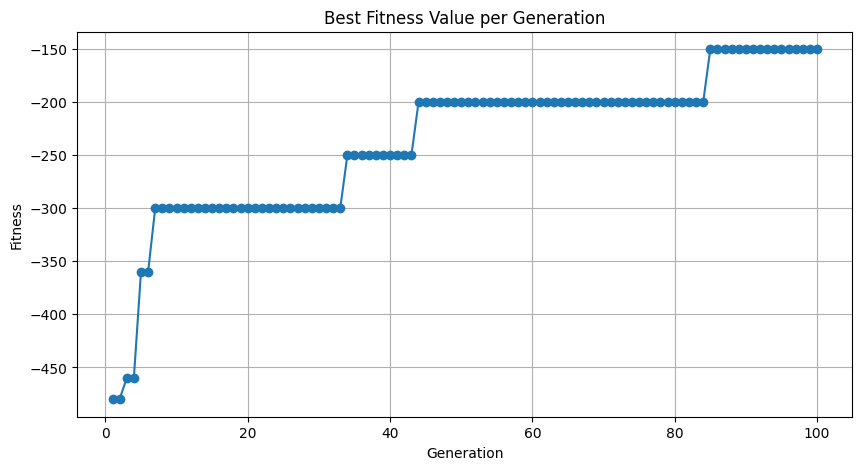


Constraints Fulfillment Summary:
                                  Constraint                       Status
0                     Every course scheduled                         True
1          No overlapping exams for students  Checked in fitness function
2   Exams only on weekdays & between 9AM-5PM                         True
3  No teacher scheduled at overlapping times  Checked in fitness function
4  No consecutive invigilation for a teacher  Checked in fitness function
5                     Valid room assignments                         True
6             Friday break (1-2 PM) achieved                         True
7         No back-to-back exams for students         Evaluated in fitness
8    MG before CS for dual-enrolled students         Evaluated in fitness
9        Two-hour break for faculty meetings         Evaluated in fitness


In [22]:
import pandas as pd
import numpy as np
import random
import matplotlib.pyplot as plt

courses_df = pd.read_csv("courses.csv")
student_course_df = pd.read_csv("studentCourse.csv")
student_names_df = pd.read_csv("studentNames.csv")
teachers_df = pd.read_csv("teachers.csv")

courses_df['Duration'] = [random.choice([1, 2]) for _ in range(len(courses_df))]

# Assign random allowed rooms per course (simulate)
all_rooms = [f"C30{i}" for i in range(1, 11)]
courses_df['Allowed Rooms'] = [random.sample(all_rooms, k=random.randint(2, 4)) for _ in range(len(courses_df))]

# Build lookup dictionaries
course_duration_map = dict(zip(courses_df['Course Code'], courses_df['Duration']))
course_room_map = dict(zip(courses_df['Course Code'], courses_df['Allowed Rooms']))


# For this scaffold, assume allowed rooms are predefined:
allowed_rooms = [f"C30{i}" for i in range(1, 11)]  # C301 to C310

# Days and time slots (assuming hour slots from 9 to 16, exam duration 1-2 hours)
weekdays = ['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday']
start_times = list(range(9, 17))  # Exams start from 9AM to 4PM (ending by 5PM)

# ============================
# GA Parameters
# ============================
POPULATION_SIZE = 50
GENERATIONS = 100
MUTATION_RATE = 0.1  # 10%
ELITISM_COUNT = 3

# ============================
# Chromosome Representation
# ============================
# Each gene: dictionary representing one exam schedule for a course.
# For simplicity, we assume each course needs one exam.
# Chromosome: list of genes, one for each course in courses_df.

def generate_random_gene(course_code):
    gene = {
        'course_code': course_code,
        'duration': course_duration_map[course_code],
        'day': random.choice(weekdays),
        'start_time': random.choice(start_times),
        'room': random.choice(course_room_map[course_code]),
        'invigilator': random.choice(teachers_df['Names'].tolist())
    }
    return gene


def generate_chromosome():
    """Generate a chromosome (schedule) covering all courses."""
    chromosome = []
    for course in courses_df['Course Code']:
        gene = generate_random_gene(course)
        chromosome.append(gene)
    return chromosome

def generate_initial_population(population_size=POPULATION_SIZE):
    """Generate the initial population."""
    return [generate_chromosome() for _ in range(population_size)]

def fitness_function(chromosome):
    fitness = 0
    penalty = 0

    # --------------------------
    # HARD CONSTRAINTS
    # --------------------------

    student_exam_times = {}

    for gene in chromosome:
      course = gene['course_code']
      day = gene['day']
      start = gene['start_time']
      end = start + gene['duration']
      students = student_course_df[student_course_df['Course Code'] == course]['Student Name'].tolist()

      for student in students:
          if student not in student_exam_times:
              student_exam_times[student] = []
          student_exam_times[student].append((day, start, end))

    # Check for time overlaps
    for student, exams in student_exam_times.items():
        for i in range(len(exams)):
            for j in range(i+1, len(exams)):
                day1, s1, e1 = exams[i]
                day2, s2, e2 = exams[j]
                if day1 == day2 and not (e1 <= s2 or e2 <= s1):
                    penalty += 50

    # 2. Exams must be Mon–Fri and between 9–16 (ending by 5)
    for gene in chromosome:
        if gene['day'] not in weekdays:
            penalty += 50
        if gene['start_time'] not in start_times:
            penalty += 50

    # 3. No teacher in overlapping exams
    time_teacher_mapping = {}
    for gene in chromosome:
        time_slot = (gene['day'], gene['start_time'])
        if time_slot not in time_teacher_mapping:
            time_teacher_mapping[time_slot] = []
        time_teacher_mapping[time_slot].append(gene['invigilator'])
    for teachers in time_teacher_mapping.values():
        for teacher in set(teachers):
            if teachers.count(teacher) > 1:
                penalty += 50 * (teachers.count(teacher) - 1)

    # 4. No consecutive invigilations for teachers
    for teacher in teachers_df['Names'].tolist():
        schedule = {}
        for gene in chromosome:
            if gene['invigilator'] == teacher:
                day = gene['day']
                if day not in schedule:
                    schedule[day] = []
                schedule[day].append(gene['start_time'])
        for day_times in schedule.values():
            sorted_times = sorted(day_times)
            for i in range(len(sorted_times) - 1):
                if sorted_times[i+1] - sorted_times[i] == 1:
                    penalty += 30

    # 5. Room validation
    for gene in chromosome:
        if gene['room'] not in allowed_rooms:
            penalty += 50

    # --------------------------
    # SOFT CONSTRAINTS
    # --------------------------

    # 1. Friday Break (1–2 PM) — No exams at 13 on Friday
    exams_friday_1 = [g for g in chromosome if g['day'] == 'Friday' and g['start_time'] == 13]
    if not exams_friday_1:
        fitness += 30
    else:
        penalty += 100 * len(exams_friday_1)

    # 2. No back-to-back exams for students
    for student, times in student_exam_times.items():
        times_by_day = {}
        for day, start, end in times:
            if day not in times_by_day:
                times_by_day[day] = []
            times_by_day[day].append(start)
    for time_list in times_by_day.values():
            time_list.sort()
            for i in range(len(time_list)-1):
                if time_list[i+1] - time_list[i] == 1:
                    penalty += 20  # Penalize per occurrence

    # 3. MG before CS rule
    for student in student_exam_times:
        courses_taken = student_course_df[student_course_df['Student Name'] == student]['Course Code'].tolist()
        mg_courses = [c for c in courses_taken if c.startswith('MG')]
        cs_courses = [c for c in courses_taken if c.startswith('CS')]
        mg_times = []
        cs_times = []
        for gene in chromosome:
            if gene['course_code'] in mg_courses:
                mg_times.append((weekdays.index(gene['day']), gene['start_time']))
            if gene['course_code'] in cs_courses:
                cs_times.append((weekdays.index(gene['day']), gene['start_time']))
        if mg_times and cs_times:
            if max(mg_times) > min(cs_times):
                penalty += 30  # heavier penalty

    # 4. Faculty meeting slot (at least half free in 2 fixed slots)
    meeting_slots = [('Wednesday', 14), ('Thursday', 15)]
    for day, time in meeting_slots:
        busy_teachers = set()
        for gene in chromosome:
            if gene['day'] == day and gene['start_time'] == time:
                busy_teachers.add(gene['invigilator'])
        total_teachers = set(teachers_df['Names'].tolist())
        free_teachers = total_teachers - busy_teachers
        if len(free_teachers) >= len(total_teachers) // 2:
            fitness += 10  # reward
        else:
            penalty += 10  # small penalty

    # Final fitness score
    return fitness - penalty

# ============================
# Selection: Roulette Wheel
# ============================
def roulette_wheel_selection(population, fitnesses):
    """
    Select a chromosome from the population using roulette wheel selection.
    """
    total_fitness = sum(fitnesses)
    if total_fitness <= 0:
        # If all fitnesses are non-positive, choose a random chromosome.
        return random.choice(population)

    pick = random.uniform(0, total_fitness)
    current = 0
    for chromosome, fit in zip(population, fitnesses):
        current += fit
        if current > pick:
            return chromosome
    return population[-1]

# ============================
# Crossover: One-Point Crossover
# ============================
def crossover(parent1, parent2):
    """
    Perform one-point crossover on two parent chromosomes.
    """
    # Random crossover point:
    point = random.randint(1, len(parent1) - 1)
    child1 = parent1[:point] + parent2[point:]
    child2 = parent2[:point] + parent1[point:]
    return child1, child2

# ============================
# Mutation
# ============================
def mutate(chromosome, mutation_rate=MUTATION_RATE):
    """
    Randomly mutate a chromosome.
    """
    new_chromosome = []
    for gene in chromosome:
        new_gene = gene.copy()
        if random.random() < mutation_rate:
            # Randomly decide which part to mutate: day, start_time, room, or invigilator.
            mutation_choice = random.choice(['day', 'start_time', 'room', 'invigilator'])
            if mutation_choice == 'day':
                new_gene['day'] = random.choice(weekdays)
            elif mutation_choice == 'start_time':
                new_gene['start_time'] = random.choice(start_times)
            elif mutation_choice == 'room':
                new_gene['room'] = random.choice(allowed_rooms)
            elif mutation_choice == 'invigilator':
                new_gene['invigilator'] = random.choice(teachers_df['Names'].tolist())
        new_chromosome.append(new_gene)
    return new_chromosome

# ============================
# GA Main Loop
# ============================
def run_ga():
    population = generate_initial_population(POPULATION_SIZE)
    best_fitness_per_generation = []
    best_chromosome = None
    best_fitness = -float('inf')

    for generation in range(GENERATIONS):
        # Calculate fitness for each chromosome
        fitnesses = [fitness_function(chrom) for chrom in population]

        # Logging best individuals in this generation
        generation_best_index = np.argmax(fitnesses)
        generation_best_fitness = fitnesses[generation_best_index]
        generation_best_chromosome = population[generation_best_index]

        print(f"Generation {generation+1}: Best Fitness = {generation_best_fitness}")
        best_fitness_per_generation.append(generation_best_fitness)

        # Update overall best
        if generation_best_fitness > best_fitness:
            best_fitness = generation_best_fitness
            best_chromosome = generation_best_chromosome

        new_population = []

        # Elitism: carry forward top individuals unchanged
        sorted_population = [chrom for _, chrom in sorted(zip(fitnesses, population), key=lambda x: x[0], reverse=True)]
        new_population.extend(sorted_population[:ELITISM_COUNT])

        # Create new population via selection, crossover, and mutation
        while len(new_population) < POPULATION_SIZE:
            parent1 = roulette_wheel_selection(population, fitnesses)
            parent2 = roulette_wheel_selection(population, fitnesses)
            # Crossover
            child1, child2 = crossover(parent1, parent2)
            # Mutation
            child1 = mutate(child1)
            child2 = mutate(child2)
            new_population.append(child1)
            if len(new_population) < POPULATION_SIZE:
                new_population.append(child2)

        population = new_population

    # Final best schedule:
    return best_chromosome, best_fitness, best_fitness_per_generation

# ============================
# Visualization
# ============================
def plot_fitness(generations, fitness_values):
    plt.figure(figsize=(10, 5))
    plt.plot(range(1, generations+1), fitness_values, marker='o')
    plt.title("Best Fitness Value per Generation")
    plt.xlabel("Generation")
    plt.ylabel("Fitness")
    plt.grid(True)
    plt.show()

# ============================
# Run the Genetic Algorithm
# ============================
best_schedule, best_schedule_fitness, fitness_progress = run_ga()

print("\nBest Schedule Found with Fitness:", best_schedule_fitness)
# Display the best schedule in a DataFrame for better visualization:
best_schedule_df = pd.DataFrame(best_schedule)


# Color-code Friday 1 PM exams, and show day-wise highlights
def highlight_friday_break(row):
    if row['day'] == 'Friday' and row['start_time'] == 13:
        return ['background-color: green'] * len(row)
    elif row['day'] == 'Friday':
        return ['background-color: blue'] * len(row)
    elif row['day'] == 'Monday':
        return ['background-color: red'] * len(row)
    else:
        return [''] * len(row)

styled_schedule = best_schedule_df.style.apply(highlight_friday_break, axis=1)
styled_schedule


from IPython.display import display

# Display the styled color-coded schedule
display(styled_schedule)

# Plot fitness progress over generations
plot_fitness(GENERATIONS, fitness_progress)


# ============================
# Display constraints fulfillment summary (placeholder)
# ============================
def display_constraints_summary(schedule):
    # In a real implementation, analyze the schedule and list which constraints (hard and soft) are met.
    summary = {
        "Every course scheduled": True,
        "No overlapping exams for students": "Checked in fitness function",
        "Exams only on weekdays & between 9AM-5PM": True,
        "No teacher scheduled at overlapping times": "Checked in fitness function",
        "No consecutive invigilation for a teacher": "Checked in fitness function",
        "Valid room assignments": True,
        "Friday break (1-2 PM) achieved": all(gene['day'] != 'Friday' or gene['start_time'] != 13 for gene in schedule),
        "No back-to-back exams for students": "Evaluated in fitness",
        "MG before CS for dual-enrolled students": "Evaluated in fitness",
        "Two-hour break for faculty meetings": "Evaluated in fitness"
    }
    summary_df = pd.DataFrame(list(summary.items()), columns=["Constraint", "Status"])
    return summary_df

constraints_summary_df = display_constraints_summary(best_schedule)
print("\nConstraints Fulfillment Summary:")
print(constraints_summary_df)


